In [1]:
# importing needed packages
import pandas as pd
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
from matplotlib import pyplot
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
import spacy
import en_core_web_sm
import itertools

# Business understanding

If you are a host on AirBnB and you wanna be successful in renting your apartment, you need to know what other hosts  offer on the platform and what exactly guests value in other apartments. One of the best sources of information helping to answer these questions is the website [Inside AirBnB](http://insideairbnb.com/get-the-data.html), which gives access to text descriptions written by hosts and guests' reviews. The following notebook shows how you can conduct text analysis of the descriptions and reviews on AirBnB to extract useful knowledge that could help to adjust an apartment description on AirBnB to the needs of potential guests and to more effectively compete with other hosts.

The questions, I am going to answer in this notebook, are:

- How different Berlin districts based on the text descriptions from AirBnB? 

- What are the distinctive words for the descriptions of apartments from different districts?

- What do guests of the apartments in these districts like the most?

# Data understanding

Before delving into text analysis, we need to explore the datasets we are going to use. 

The first dataset (listings) contains all the information from the reviews of Berlin apartments. In this dataset, you can find text descriptions of the apartments, cancellation policies, number of rooms, prices, etc.

In [119]:
listings = pd.read_csv('./data/listings.csv')

In [39]:
listings.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1944,https://www.airbnb.com/rooms/1944,20190711004031,2019-07-11,cafeheaven Pberg/Mitte/Wed for the summer 2019,"Private, bright and friendly room. You'd be sh...","The room is very large, private, cozy, bright,...","Private, bright and friendly room. You'd be sh...",none,near all the trendy cafés and flea markets and...,...,f,f,moderate,f,f,1,0,1,0,0.25


In [40]:
listings.shape

(24395, 106)

As we can see, most of the apartments on AirBnB are located in the central districts (neighboourhood groups) located close to main tourist attractions, bars, restaurants, and clubs. Residents of Berlin, living not so close to the centre, more rarely offer their places for renting on AirBnB.

In [41]:
listings['neighbourhood_group_cleansed'].value_counts()

Friedrichshain-Kreuzberg    5854
Mitte                       5082
Pankow                      3818
Neukölln                    3753
Charlottenburg-Wilm.        1766
Tempelhof - Schöneberg      1610
Lichtenberg                  792
Treptow - Köpenick           647
Steglitz - Zehlendorf        489
Reinickendorf                304
Marzahn - Hellersdorf        142
Spandau                      138
Name: neighbourhood_group_cleansed, dtype: int64

Based on the calculated standard deviations, we can see that the most of the districts have very high spread of prices (in \\$ per night). It means that prices vary significantly in the districts, and, in most of the them, people with very different budgets can find a place for living. By comparing mean and median values, we also can say that mean prices are skewed to positive side. It means that the districts have some outlying apartments with very high prices. Looking at medians, we can say that for most of the districts, normal price per night is 40-50 $. The cheapest apartments can be found in Reinickendord and Spandau. The highest median price relates to Pankow. 

Looking at the median numbers of reviews, we can see that that, normally, one apartment gets 3-5 reviews. Interesting finding is that the district Marzahn - Hellersdorf (which is marginalised in media for having negative attitudes towards migrants) has the highest number of reviews. 

Speaking about aggregated reviews scores, this measure is not very useful for us; the districts have very similar scores according to it.

In [120]:
listings['price'] = listings["price"].replace('[^0-9\\.]', "", regex = True) 
listings['price'] = pd.to_numeric(listings['price'])
listings.groupby('neighbourhood_group_cleansed').agg(
    {
         'price':['mean', 'std', 'median'],
         'number_of_reviews':['mean', 'std', 'median'],
         'review_scores_rating':['mean', 'std', 'median']
    }
)

price                    number_of_reviews  \
                                    mean         std median              mean   
neighbourhood_group_cleansed                                                    
Charlottenburg-Wilm.          109.463760  497.318718   50.0         20.184598   
Friedrichshain-Kreuzberg       65.167578  130.510982   50.0         18.974376   
Lichtenberg                    66.103535  335.172430   40.0         15.023990   
Marzahn - Hellersdorf          61.422535   56.695069   50.0         20.112676   
Mitte                          75.461629  102.903209   50.0         24.510232   
Neukölln                       49.185718   35.080244   40.0         14.394085   
Pankow                         72.893662  136.625755   55.0         22.047407   
Reinickendorf                  46.605263   34.277004   36.5         18.779605   
Spandau                        59.826087   53.577546   38.5         14.050725   
Steglitz - Zehlendorf          60.364008   66.955013   47.0         14.476483   
Tempelhof - Schöneberg         97.655901  470.026127   46.0         19.349068   
Treptow - Köpenick             57.024730   47.418491   45.0         14.238022   

                                               review_scores_rating  \
                                    std median                 mean   
neighbourhood_group_cleansed                                          
Charlottenburg-Wilm.          38.563805    4.5            94.370096   
Friedrichshain-Kreuzberg      40.625509    4.0            94.821046   
Lichtenberg                   31.201854    4.0            93.795341   
Marzahn - Hellersdorf         30.564917    8.5            94.918182   
Mitte                         50.143989    5.0            93.966438   
Neukölln                      32.958097    4.0            95.009735   
Pankow                        45.827742    5.0            95.059755   
Reinickendorf                 36.696068    5.0            94.548246   
Spandau                       31.242710    3.0            93.742574   
Steglitz - Zehlendorf         23.723734    5.0            95.119363   
Tempelhof - Schöneberg        37.730323    5.0            94.989930   
Treptow - Köpenick            28.173702    4.0            95.484970   

                                                
                                    std median  
neighbourhood_group_cleansed                    
Charlottenburg-Wilm.           7.423733   97.0  
Friedrichshain-Kreuzberg       7.632768   97.0  
Lichtenberg                   10.067756   97.0  
Marzahn - Hellersdorf          6.352247   97.0  
Mitte                          8.007017   96.0  
Neukölln                       6.982967   97.0  
Pankow                         6.778612   97.0  
Reinickendorf                  7.143115   97.0  
Spandau                        8.570477   97.0  
Steglitz - Zehlendorf          7.567714   98.0  
Tempelhof - Schöneberg         7.236368   97.0  
Treptow - Köpenick             6.083198   98.0

The second dataset we need includes all the reviews, written by guests, for Berlin apartments.

In [121]:
reviews = pd.read_csv('./data/reviews.csv')

In [122]:
reviews.shape

(479327, 6)

In [123]:
reviews.head(1)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1944,7126992,2013-09-07,8207524,Mirko,I want to thank Laura&Emiliano for their hospi...


As the dataset with reviews does not have information on the districts, we need to take this information from the listings dataset.

In [124]:
reviews = pd.merge(reviews, listings[['id', 'neighbourhood_group_cleansed']], how='left', left_on=['listing_id'], right_on=['id'])

# Data preparation

As I work with the texts in this project, I need to clean them before creating a document-term matrix and calculating different measures. In the case of apartments' descriptions, I kept only English words, removed numbers, punctuation, and stopwords.

In [10]:
nltk.download() # installing all needed data for nltk

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [138]:
# replacing all non-English words, numbers, punctuation, stopwords
words = set(nltk.corpus.words.words()) # making a list with only English words
stop_words=set(stopwords.words("english")) # making a list with stopwords for English language

def clean_descriptions(x):
    """
    This function removes all non-English words, numbers, punctuation, stopwords

    Arguments:
        x: string or Pandas series 

    Returns:
        cleaned string
    """
    return " ".join(w.lower() for w in nltk.wordpunct_tokenize(x) \
         if w.lower() in words and w.lower() not in stop_words and w.isalpha())

listings['description_cleaned'] = listings['description'].apply(lambda x: clean_descriptions(str(x)))

listings = listings.dropna(subset=['description_cleaned']) # removing rows having NA in the column with cleaned descriptions

In [139]:
# uniting the texts on the base of the neighborhoods

listings_agg = listings.groupby('neighbourhood_group_cleansed')['description_cleaned'].apply(lambda x: ''.join(str(list(x)))).reset_index()

Guests often mention hosts in reviews, and these names could become distinctive words differentiating one district from another. Such distinctive words are meaningless for us, so we have to remove names.

In [151]:
# as the dataset is too big, let's work only with two neighbourhoods I decided to explore in the framework of the current study
reviews_filtered = reviews[reviews['neighbourhood_group_cleansed'].isin(['Friedrichshain-Kreuzberg', 'Steglitz - Zehlendorf'])]

In [128]:
# loading model package that allows to identify entities in texts
nlp = en_core_web_sm.load()

In [133]:
def names_extractor(x):
    """
    This function extracts names from the texts

    Arguments:
        x: string or Pandas series

    Returns:
        list with all names for x
    """
    doc = nlp(x)
    entities = [(X.text, X.label_) for X in doc.ents]
    names = [t for t in entities if t[1] == 'PERSON']
    return [x[0] for x in names]

names_nested = reviews_filtered['comments'].apply(lambda x: names_extractor(str(x)))

In [134]:
# making flatten list with unqiue names
names = [name.lower() for names in list(itertools.chain(names_nested)) for name in names]
names = set(names)

In [136]:
def clean_reviews(x):
    """
    This function removes all non-English words, numbers, punctuation, stopwords, names

    Arguments:
        x: string or Pandas series 

    Returns:
        cleaned string
    """
    return " ".join(w.lower() for w in nltk.wordpunct_tokenize(x) \
         if w.lower() in words and w.lower() not in names and w.lower() not in stop_words and w.isalpha())

reviews_filtered['comments_cleaned'] = reviews_filtered['comments'].apply(lambda x: clean_reviews(str(x)))
reviews_filtered = reviews_filtered.dropna(subset=['comments_cleaned']) # removing rows with NA in the column with cleaned comments

# Data analysis

## How different Berlin districts based on the text descriptions from AirBnB?

To answer this question, I, first, need to transform text corpus into document-term matrix and, after that, calculate cosine similarity, which would show how Berlin districts differ on the base of words from descriptions given by hosts. Then, I  calculated multidimensional scaling (MDS) to present the distances between the districts on 2D scatter plot.

In [279]:
# creating document-term matrix
vectorizer = CountVectorizer(input='content')
dtm = vectorizer.fit_transform(listings_agg['description_cleaned'])
vocab = np.array(vectorizer.get_feature_names())
dtm = dtm.toarray()

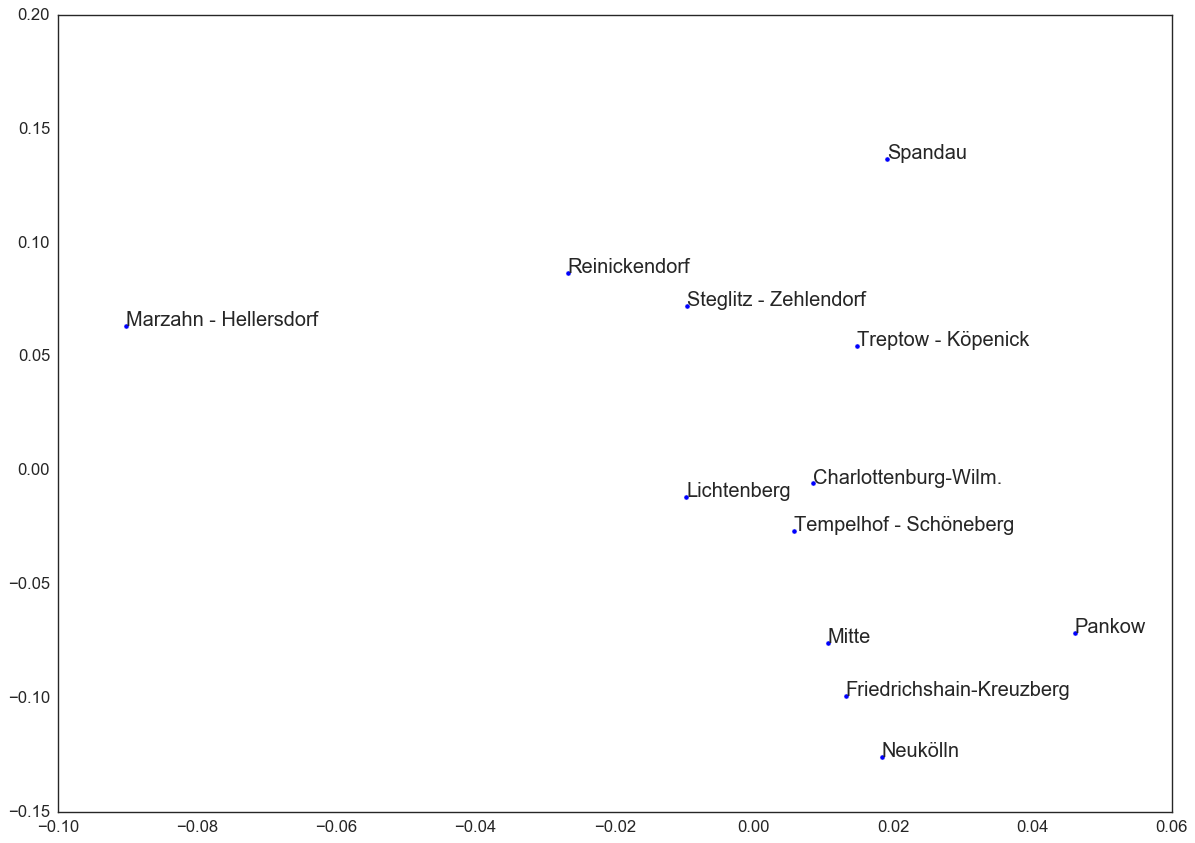

In [292]:
# counting cosine similarity and drawing results with help of MDS
dist = 1 - cosine_similarity(dtm)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]
names = listings_agg['neighbourhood_group_cleansed']


for x, y, name in zip(xs, ys, names):
    plt.scatter(x, y)
    plt.text(x, y, name)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size
plt.style.use('seaborn-white')
plt.savefig('mapping.png', bbox_inches = 'tight')

## What are the distinctive words for the descriptions of apartments from different districts?

To answer the second question, I wrote the fucntion, which calculates log odds ratio allowing me to explore distinctive words for two compared districts. 

In [145]:
# function which calculates log odds ratio and draws the most distinctive words
def log_ratio_compare(df, neighborhoods, text, words_threshold, num_words, save = True, name = 'output'):
    """
    Function takes texts for two neighborhoods and calculates log-likelihood ratio for words in these texts

    Arguments:
        df: dataframe with all needed neighborhoods
        neighborhoods: list with two neighborhoods you want to compare
        text (str): name of the column with texts
        words_threshold (int): all words that occur less than chosen threshold will be removed
        num_words (int): how many distinctive words will appear in the final charts for each neighborhood
        save (boolean): saves the final chart
        name(str): how the chart should be called. default name is 'output'

    Returns:
        a chart with the most distinctive words for each neighborhood
    """    
    # creating document-term matrix
    listings_chosen = df[df['neighbourhood_group_cleansed'].isin(neighborhoods)]
    labels = listings_chosen['neighbourhood_group_cleansed'].apply(lambda x: 'first' if x == neighborhoods[0]
                                                          else 'second')
    vectorizer = CountVectorizer(input='content')
    dtm = vectorizer.fit_transform(listings_chosen[text])
    vocab = np.array(vectorizer.get_feature_names())
    dtm = dtm.toarray()
    words = vocab[np.sum(dtm, axis = 0) > words_threshold]
    
    # calculating log odds ratio
    X = dtm[:, np.in1d(vocab,words)]
    X = X.T + 1
    logs = np.log((X[:, labels == 'first'] / np.sum((dtm.T + 1)[:, labels == "first"])) /
                  (X[:, labels == 'second'] / np.sum((dtm.T + 1)[:, labels == "second"]))) 
    
    # creating a dataframe
    df = pd.DataFrame({'words':words, 'log':logs.flatten()})
    first = df.sort_values(by='log', ascending=True).head(num_words)
    first['district'] = np.repeat(neighborhoods[1], num_words)
    second = df.sort_values(by='log', ascending=False).head(num_words)
    second['district'] = np.repeat(neighborhoods[0], num_words)
    df = first.append(second)
    df = df.sort_values('log')
    
    # drawing a plot
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    a4_dims = (11.7, 8.27)
    fig, ax = pyplot.subplots(figsize=a4_dims)
    ax = sns.barplot(x="log", y="words", hue="district", data=df)
    ax.set(xlabel='Log odds ratio', ylabel='Words')
    ax.text(0, 0, '')
    if save:
        ax.figure.savefig(name + '.png')   

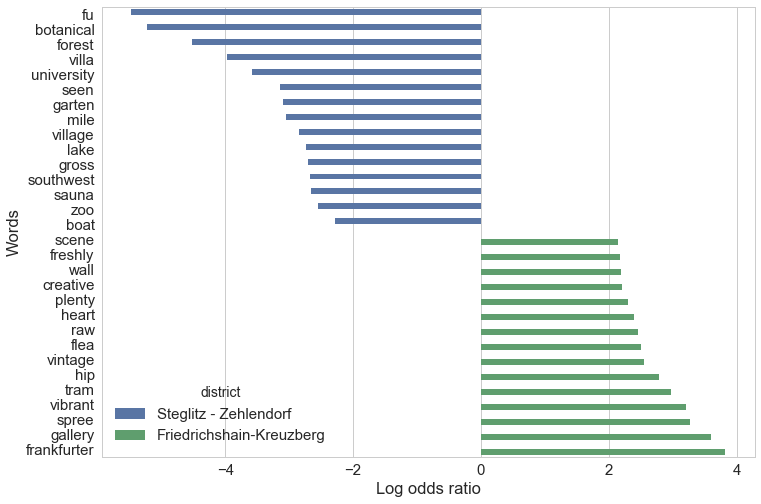

In [141]:
warnings.filterwarnings("ignore")
log_ratio_compare(listings_agg, ['Friedrichshain-Kreuzberg', 'Steglitz - Zehlendorf'], 'description_cleaned', 10, 15, 
               name = 'descriptions')

In [144]:
# looking at the context in which the words occur
list(listings['description'][(listings['neighbourhood_group_cleansed'] == 'Friedrichshain-Kreuzberg') & 
                             (listings['description_cleaned'].str.contains('\ship\s', regex=True))])[1]

"A clean minimal-held apartment perfect for couples and small family in the heart of Kreuzberg and Bergmannkiez, an area with a mix of old and new architecture, supermarkets and market hall, hip cafés and restaurants. Here you'll find a spacious home with high Altbau ceilings and original wooden floors, a fully equipped kitchen, washing machine, dishwasher, and Wi-Fi.   The apartment's layout and the interior furnishing is kid-friendly yet still subtle & modern. Feel free to contact me with any questions. Oliver Entire Apartment Some recommended places that are close by: Marheineke Platz (Weekend Flea Market & daily market hall) Chamisso Platz (Saturday Organic Market) Bergmannstrasse (Cafes & Restaurants) Tempelhof Airport (amazing for walks, picnics, kite surfing, etc) Victoria Park (great view over Berlin) Park am Gleisdreieck (converted rail crossing) Chapter One (great coffee) Multiple Playgrounds in the near vicinity Many public transportation options are available close by.  In 

## What do guests of the apartments in these districts like the most?

In this part of the work, I, first, identified positive reviews with help of sentiment analysis and applied the function from the previous chapter to reveal how the words from positive reviews differ for two districts.

In [146]:
# employing sentiment analysis
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    """
This function calculates sentiment score for the sentence

Arguments:
    sentence: string or Pandas series 

Returns:
    sentiment score. if the score is less than 0, it means that a sentence is negative, and vice versa
"""
    score = analyser.polarity_scores(sentence)
    return score.get('compound')

In [147]:
reviews_filtered['sentiment'] = reviews_filtered['comments_cleaned'].apply(lambda x: sentiment_analyzer_scores(x)) 

In [148]:
# leaving only positive reviews
good_reviews = reviews_filtered[(reviews_filtered['sentiment'] > 0)]

In [149]:
# uniting positive reviews on the base of neighborhoods
reviews_agg = good_reviews.groupby('neighbourhood_group_cleansed')['comments_cleaned'].apply(lambda x: ''.join(str(list(x)))).reset_index()

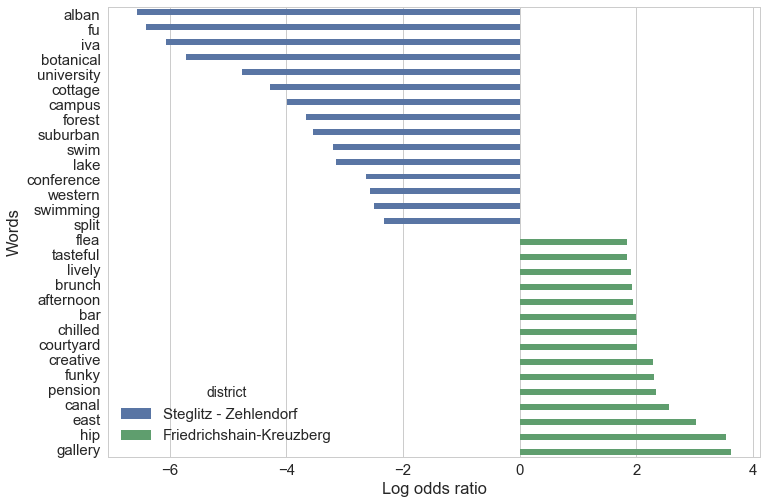

In [152]:
# calculating log odds ratio and drawing the most distinctive words
log_ratio_compare(reviews_agg, ['Friedrichshain-Kreuzberg', 'Steglitz - Zehlendorf'],'comments_cleaned', 10, 15, 
                name = 'reviews')

In [164]:
# looking at the context in which the words occur
list(good_reviews['comments'][(good_reviews['neighbourhood_group_cleansed'] == 'Friedrichshain-Kreuzberg') & 
                             (good_reviews['comments_cleaned'].str.contains('\screative\s', regex = True))])[2]

"I stayed at Desiree's place for a couple of days and had a good time. The location is amazing, you can explore the alternative and creative side of Berlin and the apartment is super close to many nice places. The room was cozy, bright, stylish and warm and the landscape was unforgettable. Also Desiree was a lovely host, she was helpful and gracious in addition she definitely makes you feel at a wonderful place. I highly recommend Desiree's apartment."

# Results evaluation

Due to such type of analysis, renters can follow how the processes of supply and demand work on AirBnB market. For more detailed exploration, it would be interesting to study how word usage changes depending on different seasons or compare negative and positive reviews. Also, one interesting challenge is to work with different languages as the reviews and descriptions are not always written in English. For this research, all non-English texts were removed, but I expect we could find more interesting results if we would include all the languages. It assumes more efforts from the side of a data analyst, as all the texts should be translated into one language for a proper comparison.